In [150]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [243]:

# get historical daily price for SPY and ^VIX
sector_list = ['XLE','XLF','XLU','XLI','XLK','XLV','XLY','XLP','XLB']
ticker_list = ['^VIX','^TNX','^IRX']
ticker_list.extend(sector_list)
spy_history = yf.Ticker('SPY').history(period="max")
ret = np.log(spy_history.Close) - np.log(spy_history.Close.shift(1))
spy_history['ret']=ret

df=pd.DataFrame()
df['SPY_ret'] = spy_history['ret']
df['SPY'] = spy_history.Close


for x in ticker_list:
    if x.startswith('^'):        
        tmp = yf.Ticker(x).history(period="max")
        tmp[x] = tmp.Close
        tmp = tmp[[x]]
        df = pd.merge(df,tmp,how='left',on=['Date'])
    else:
        tmp = yf.Ticker(x).history(period="max")
        print(x,tmp.columns)
        tmp[x+"_ret"]=np.log(tmp.Close) - np.log(tmp.Close.shift(1))
        tmp = tmp[[x+"_ret"]]
        df = pd.merge(df,tmp,how='left',on=['Date'])
df = df.dropna()
odf = df.copy()
print(df.shape)
print(df.index[0],df.index[-1])

XLE Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
XLF Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
XLU Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
XLI Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
XLK Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
XLV Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
XLY Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
XLP Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
XLB Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
(5994, 14)
1998-12-23 00:00:00-05:00 2022-10-31 00:00:00-04:00


In [245]:
df.columns

Index(['SPY_ret', 'SPY', '^VIX', '^TNX', '^IRX', 'XLE_ret', 'XLF_ret',
       'XLU_ret', 'XLI_ret', 'XLK_ret', 'XLV_ret', 'XLY_ret', 'XLP_ret',
       'XLB_ret'],
      dtype='object')

In [246]:
m2sl_url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=M2SL&scale=left&cosd=1959-01-01&coed=2022-09-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2022-10-31&revision_date=2022-10-31&nd=1959-01-01'
m2sl = pd.read_csv(m2sl_url)
m2sl['Date'] = m2sl.DATE.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))
m2sl = m2sl.set_index('Date')
m2sl.index = pd.to_datetime(m2sl.index).tz_localize('est')
m2sl = m2sl.reindex(odf.index, method='ffill')
m2sl = m2sl[['M2SL']]
print(df.shape)
print(m2sl.shape)
df = odf.merge(m2sl,how='left',left_index=True,right_index=True)
print(df.shape)

(5994, 14)
(5994, 1)
(5994, 15)


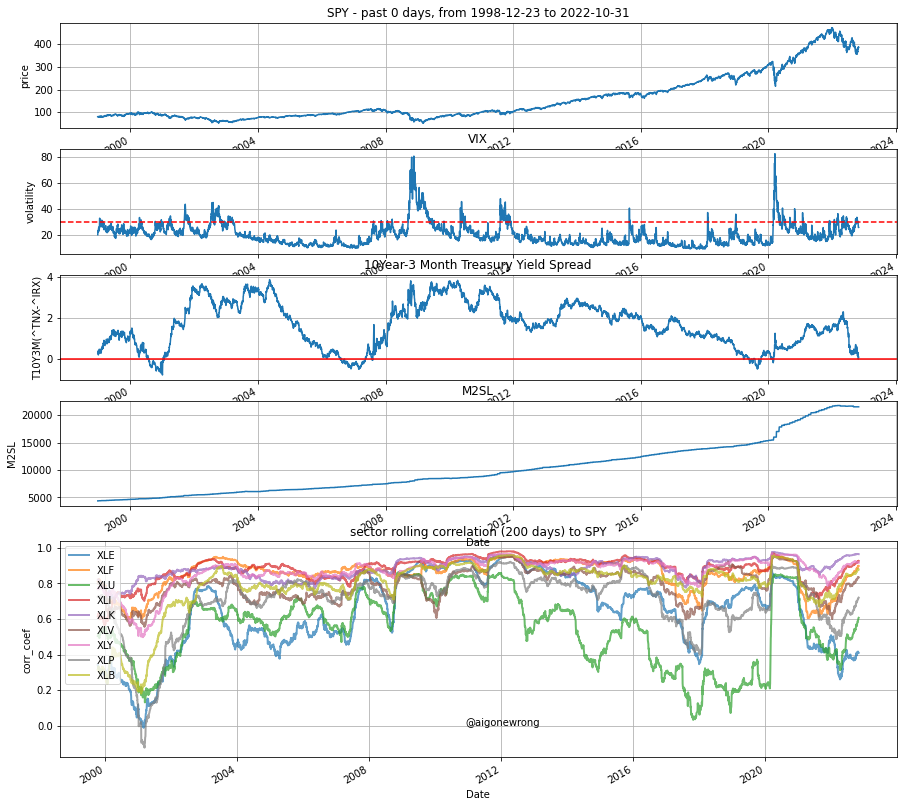

In [257]:
roll = 200
lookback = 0
plt.figure(figsize=(15,15))

last_date = df.index[-1].strftime('%Y-%m-%d')
start_date = df.index[lookback].strftime('%Y-%m-%d')
mid_idx = df.index[len(df.index)//2]
plt.subplot(313)
for x in sector_list:
    a = df[x+"_ret"].rolling(roll).corr(df['SPY_ret'])
    a[lookback:].plot(label=x,alpha=0.7,linewidth=2,linestyle='-')
plt.legend(loc = "upper left")
plt.ylabel('corr_coef')
plt.text(mid_idx,0,'@aigonewrong')
plt.title(f'sector rolling correlation ({roll} days) to SPY')
plt.grid(True)

plt.subplot(611)
df['SPY'][lookback:].plot()
plt.ylabel('price')
plt.title(f'SPY - past {np.abs(lookback)} days, from {start_date} to {last_date}')
plt.grid(True)
plt.subplot(612)
df['^VIX'][lookback:].plot()
plt.axhline(30,color='r',linestyle='--')
plt.ylabel('volatility')
plt.title(f'VIX')
plt.grid(True)
plt.subplot(613)
(df['^TNX']-df['^IRX'])[lookback:].plot()
plt.axhline(0,color='r',linestyle='-')
plt.ylabel('T10Y3M(^TNX-^IRX)')
plt.title('10Year-3 Month Treasury Yield Spread')
plt.grid(True)
plt.subplot(614)
df['M2SL'][lookback:].plot()
plt.ylabel('M2SL')
plt.title('M2SL')
plt.grid(True)
